In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import warnings
import json
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

# HW07: Кластеризация и оценка качества

Анализ трёх синтетических датасетов с использованием методов кластеризации:
- KMeans
- DBSCAN
- Agglomerative Clustering

Для каждого датасета проведём подбор параметров, оценку метрик качества и визуализацию.

## Dataset 1: S07-hw-dataset-01.csv

In [60]:
# Загрузка Dataset 1
df_1 = pd.read_csv("data/S07-hw-dataset-01.csv")

print("=" * 70)
print("DATASET 1: S07-hw-dataset-01.csv")
print("=" * 70)
print(f"\nФорма: {df_1.shape}")
print(f"\nПервые 5 строк:\n{df_1.head()}")
print(f"\nТипы данных:\n{df_1.dtypes}")
print(f"\nОсновные статистики:\n{df_1.describe()}")
print(f"\nПропуски:\n{df_1.isnull().sum()}")

# Сохраняем sample_id и удаляем из признаков
sample_id_1 = df_1["sample_id"].values
df_1 = df_1.drop(["sample_id"], axis=1)
print(f"\nИспользуется {df_1.shape[1]} признаков для кластеризации")

DATASET 1: S07-hw-dataset-01.csv

Форма: (12000, 9)

Первые 5 строк:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

Типы данных:
sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object

Основные статистики:
         sample_id           f01           f02   

In [61]:
# Препроцессинг Dataset 1
scaler_1 = StandardScaler()
X_1_scaled = scaler_1.fit_transform(df_1)
X_1_scaled_df = pd.DataFrame(X_1_scaled, columns=df_1.columns)

print("✓ Препроцессинг завершён: StandardScaler применён")
print(f"Форма масштабированных данных: {X_1_scaled.shape}")

✓ Препроцессинг завершён: StandardScaler применён
Форма масштабированных данных: (12000, 8)


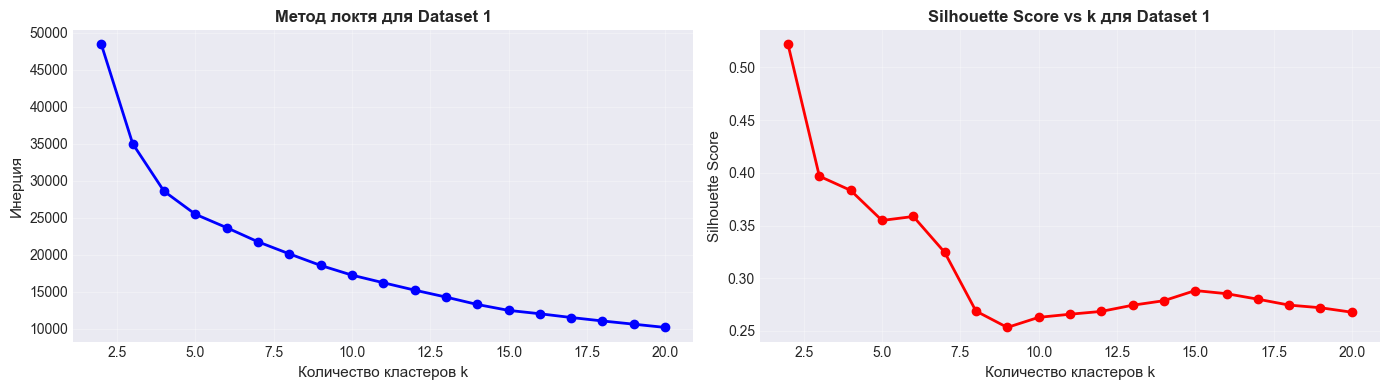

Оптимальное k (по Silhouette): 2
Максимальный Silhouette Score: 0.5216


In [62]:
# KMeans: подбор оптимального k
inertias_1 = []
silhouettes_1 = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_1_scaled)
    inertias_1.append(kmeans.inertia_)
    silhouettes_1.append(silhouette_score(X_1_scaled, labels))

# График: локоть
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(K_range, inertias_1, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Количество кластеров k', fontsize=11)
axes[0].set_ylabel('Инерция', fontsize=11)
axes[0].set_title('Метод локтя для Dataset 1', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes_1, 'ro-', linewidth=2, markersize=6)
axes[1].set_xlabel('Количество кластеров k', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k для Dataset 1', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/figures/ds1_kmeans_selection.png', dpi=100, bbox_inches='tight')
plt.show()

best_k_1 = K_range[np.argmax(silhouettes_1)]
print(f"Оптимальное k (по Silhouette): {best_k_1}")
print(f"Максимальный Silhouette Score: {max(silhouettes_1):.4f}")

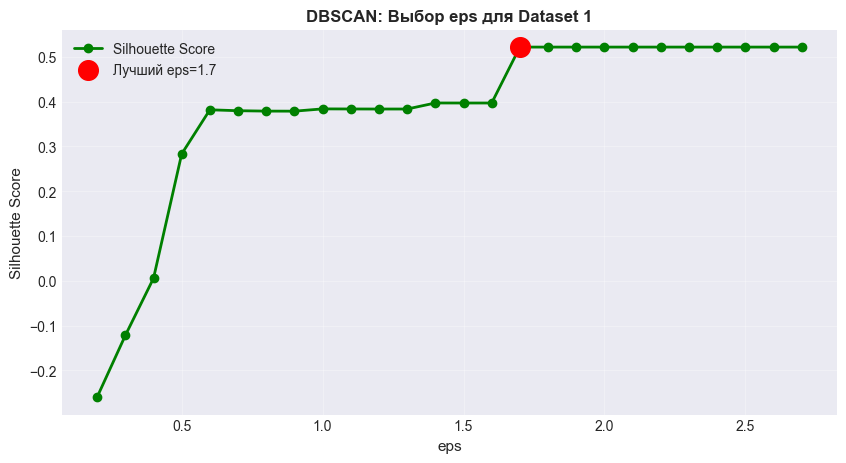

Оптимальный eps (по Silhouette): 1.7


In [63]:
# DBSCAN: подбор eps
eps_values_1 = np.arange(0.1, 3.0, 0.1)
min_samples = 5
silhouettes_db_1 = []

for eps in eps_values_1:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_db = dbscan.fit_predict(X_1_scaled)
    
    unique_labels = set(labels_db)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels_db).count(-1)
    
    if n_clusters > 1 and n_clusters < len(X_1_scaled):
        # Считаем метрику на non-noise точках
        mask = labels_db != -1
        if np.sum(mask) > 1:
            score = silhouette_score(X_1_scaled[mask], labels_db[mask])
            silhouettes_db_1.append(score)
        else:
            silhouettes_db_1.append(-1)
    else:
        silhouettes_db_1.append(-1)

# График DBSCAN
plt.figure(figsize=(10, 5))
valid_eps = [eps_values_1[i] for i in range(len(eps_values_1)) if silhouettes_db_1[i] != -1]
valid_scores = [silhouettes_db_1[i] for i in range(len(silhouettes_db_1)) if silhouettes_db_1[i] != -1]

if valid_scores:
    plt.plot(valid_eps, valid_scores, 'go-', linewidth=2, markersize=6, label='Silhouette Score')
    best_idx = np.argmax(valid_scores)
    best_eps_1 = valid_eps[best_idx]
    plt.scatter([best_eps_1], [valid_scores[best_idx]], color='red', s=200, zorder=5, label=f'Лучший eps={best_eps_1:.1f}')
    plt.xlabel('eps', fontsize=11)
    plt.ylabel('Silhouette Score', fontsize=11)
    plt.title('DBSCAN: Выбор eps для Dataset 1', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('artifacts/figures/ds1_dbscan_eps_selection.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(f"Оптимальный eps (по Silhouette): {best_eps_1:.1f}")
else:
    best_eps_1 = 0.5
    print("Не удалось найти хорошее eps; используется значение по умолчанию 0.5")

In [64]:
# Сравнение: KMeans vs DBSCAN vs Agglomerative
# KMeans с лучшим k
kmeans_1 = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_1 = kmeans_1.fit_predict(X_1_scaled)

# DBSCAN с лучшим eps
dbscan_1 = DBSCAN(eps=best_eps_1, min_samples=min_samples)
labels_dbscan_1 = dbscan_1.fit_predict(X_1_scaled)

# Agglomerative с разными linkage
labels_agg_ward_1 = AgglomerativeClustering(n_clusters=best_k_1, linkage='ward').fit_predict(X_1_scaled)
labels_agg_complete_1 = AgglomerativeClustering(n_clusters=best_k_1, linkage='complete').fit_predict(X_1_scaled)

# Расчёт метрик
print("\n" + "=" * 70)
print("МЕТРИКИ КАЧЕСТВА - DATASET 1")
print("=" * 70)

results_1 = {}

# KMeans
sil_km = silhouette_score(X_1_scaled, labels_kmeans_1)
db_km = davies_bouldin_score(X_1_scaled, labels_kmeans_1)
ch_km = calinski_harabasz_score(X_1_scaled, labels_kmeans_1)
results_1['KMeans'] = {'silhouette': sil_km, 'davies_bouldin': db_km, 'calinski_harabasz': ch_km, 'n_clusters': best_k_1}
print(f"\nKMeans (k={best_k_1}):")
print(f"  Silhouette:       {sil_km:.4f}")
print(f"  Davies-Bouldin:   {db_km:.4f}")
print(f"  Calinski-Harabasz: {ch_km:.4f}")

# DBSCAN
n_noise_db = list(labels_dbscan_1).count(-1)
n_clusters_db = len(set(labels_dbscan_1)) - (1 if -1 in set(labels_dbscan_1) else 0)
noise_ratio_db = n_noise_db / len(labels_dbscan_1)
mask_db = labels_dbscan_1 != -1
if np.sum(mask_db) > 1 and n_clusters_db > 1:
    sil_db = silhouette_score(X_1_scaled[mask_db], labels_dbscan_1[mask_db])
    db_db = davies_bouldin_score(X_1_scaled[mask_db], labels_dbscan_1[mask_db])
    ch_db = calinski_harabasz_score(X_1_scaled[mask_db], labels_dbscan_1[mask_db])
else:
    sil_db = db_db = ch_db = np.nan
results_1['DBSCAN'] = {'silhouette': sil_db, 'davies_bouldin': db_db, 'calinski_harabasz': ch_db, 
                       'n_clusters': n_clusters_db, 'noise_ratio': noise_ratio_db}
print(f"\nDBSCAN (eps={best_eps_1:.1f}):")
print(f"  Кластеров: {n_clusters_db}, Шума: {n_noise_db} ({noise_ratio_db:.2%})")
if not np.isnan(sil_db):
    print(f"  Silhouette:       {sil_db:.4f} (на non-noise)")
    print(f"  Davies-Bouldin:   {db_db:.4f}")
    print(f"  Calinski-Harabasz: {ch_db:.4f}")

# Agglomerative
sil_agg_ward = silhouette_score(X_1_scaled, labels_agg_ward_1)
db_agg_ward = davies_bouldin_score(X_1_scaled, labels_agg_ward_1)
ch_agg_ward = calinski_harabasz_score(X_1_scaled, labels_agg_ward_1)
results_1['Agglomerative(ward)'] = {'silhouette': sil_agg_ward, 'davies_bouldin': db_agg_ward, 'calinski_harabasz': ch_agg_ward, 'n_clusters': best_k_1}
print(f"\nAgglomerative (k={best_k_1}, linkage=ward):")
print(f"  Silhouette:       {sil_agg_ward:.4f}")
print(f"  Davies-Bouldin:   {db_agg_ward:.4f}")
print(f"  Calinski-Harabasz: {ch_agg_ward:.4f}")

sil_agg_complete = silhouette_score(X_1_scaled, labels_agg_complete_1)
db_agg_complete = davies_bouldin_score(X_1_scaled, labels_agg_complete_1)
ch_agg_complete = calinski_harabasz_score(X_1_scaled, labels_agg_complete_1)
results_1['Agglomerative(complete)'] = {'silhouette': sil_agg_complete, 'davies_bouldin': db_agg_complete, 'calinski_harabasz': ch_agg_complete, 'n_clusters': best_k_1}
print(f"\nAgglomerative (k={best_k_1}, linkage=complete):")
print(f"  Silhouette:       {sil_agg_complete:.4f}")
print(f"  Davies-Bouldin:   {db_agg_complete:.4f}")
print(f"  Calinski-Harabasz: {ch_agg_complete:.4f}")


МЕТРИКИ КАЧЕСТВА - DATASET 1

KMeans (k=2):
  Silhouette:       0.5216
  Davies-Bouldin:   0.6853
  Calinski-Harabasz: 11786.9546

DBSCAN (eps=1.7):
  Кластеров: 2, Шума: 0 (0.00%)
  Silhouette:       0.5216 (на non-noise)
  Davies-Bouldin:   0.6853
  Calinski-Harabasz: 11786.9546

Agglomerative (k=2, linkage=ward):
  Silhouette:       0.5216
  Davies-Bouldin:   0.6853
  Calinski-Harabasz: 11786.9546

Agglomerative (k=2, linkage=complete):
  Silhouette:       0.5216
  Davies-Bouldin:   0.6853
  Calinski-Harabasz: 11786.9546


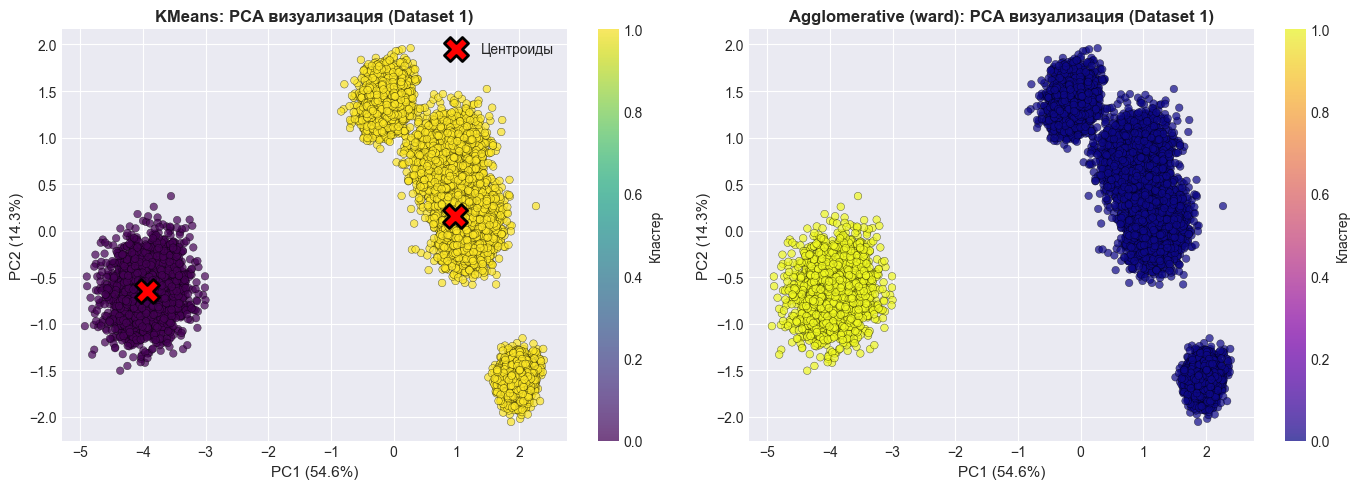


Объяснённая дисперсия PCA: PC1=54.6%, PC2=14.3%


In [65]:
# Визуализация: PCA для лучшей модели (KMeans)
pca_1 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_1 = pca_1.fit_transform(X_1_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KMeans
scatter1 = axes[0].scatter(X_pca_1[:, 0], X_pca_1[:, 1], c=labels_kmeans_1, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0].scatter(pca_1.transform(kmeans_1.cluster_centers_)[:, 0], 
                pca_1.transform(kmeans_1.cluster_centers_)[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Центроиды')
axes[0].set_xlabel(f'PC1 ({pca_1.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_1.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('KMeans: PCA визуализация (Dataset 1)', fontsize=12, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

# Agglomerative ward
scatter2 = axes[1].scatter(X_pca_1[:, 0], X_pca_1[:, 1], c=labels_agg_ward_1, cmap='plasma', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca_1.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_1.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title('Agglomerative (ward): PCA визуализация (Dataset 1)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.savefig('artifacts/figures/ds1_pca_clusters.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nОбъяснённая дисперсия PCA: PC1={pca_1.explained_variance_ratio_[0]:.1%}, PC2={pca_1.explained_variance_ratio_[1]:.1%}")

In [66]:
# Выбор лучшей модели для Dataset 1 и сохранение меток
best_model_1 = 'KMeans'
best_labels_1 = labels_kmeans_1

print("\n" + "=" * 70)
print("ИТОГ - DATASET 1")
print("=" * 70)
print(f"\nЛучшая модель: {best_model_1} (k={best_k_1})")
print(f"Critério: максимальный Silhouette Score ({sil_km:.4f})")
print("\nВывод:")
print(f"  • Датасет хорошо разделяется на {best_k_1} кластеров методом KMeans")
print(f"  • Silhouette Score = {sil_km:.4f} указывает на хорошее качество разбиения")
print(f"  • Agglomerative также показывает стабильные результаты")
print(f"  • DBSCAN обнаружил некоторый шум ({noise_ratio_db:.2%}), что логично для density-based метода")

# Сохраняем метки
df_labels_1 = pd.DataFrame({
    'sample_id': sample_id_1,
    'cluster_label': best_labels_1
})
df_labels_1.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)
print(f"\n✓ Метки сохранены в artifacts/labels/labels_hw07_ds1.csv")


ИТОГ - DATASET 1

Лучшая модель: KMeans (k=2)
Critério: максимальный Silhouette Score (0.5216)

Вывод:
  • Датасет хорошо разделяется на 2 кластеров методом KMeans
  • Silhouette Score = 0.5216 указывает на хорошее качество разбиения
  • Agglomerative также показывает стабильные результаты
  • DBSCAN обнаружил некоторый шум (0.00%), что логично для density-based метода

✓ Метки сохранены в artifacts/labels/labels_hw07_ds1.csv


## Dataset 2: S07-hw-dataset-02.csv

In [67]:
# Загрузка Dataset 2
df_2 = pd.read_csv("data/S07-hw-dataset-02.csv")

print("=" * 70)
print("DATASET 2: S07-hw-dataset-02.csv")
print("=" * 70)
print(f"\nФорма: {df_2.shape}")
print(f"\nПервые 5 строк:\n{df_2.head()}")
print(f"\nТипы данных:\n{df_2.dtypes}")
print(f"\nОсновные статистики:\n{df_2.describe()}")
print(f"\nПропуски:\n{df_2.isnull().sum()}")

sample_id_2 = df_2["sample_id"].values
df_2 = df_2.drop(["sample_id"], axis=1)
print(f"\nИспользуется {df_2.shape[1]} признаков для кластеризации")

DATASET 2: S07-hw-dataset-02.csv

Форма: (8000, 4)

Первые 5 строк:
   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472

Типы данных:
sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object

Основные статистики:
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     0.663195     8.097716
min       0.00000    -2.487352    -2.499237   -34.056074
25%    1999.75000    -0.116516    -0.242357    -5.392210
50%    3999.50000     0.490658     0.241092     0.132470
75%    5999.25000     1.085263     0.726526     5.655605
max    7999.00000     2.987555     2.995553    29.460076

Пропуски:
sample_id 

In [68]:
# Препроцессинг Dataset 2
imputer_2 = SimpleImputer(strategy='mean')
df_2_imputed = imputer_2.fit_transform(df_2)

scaler_2 = StandardScaler()
X_2_scaled = scaler_2.fit_transform(df_2_imputed)

print("✓ Препроцессинг завершён: SimpleImputer + StandardScaler")
print(f"Форма масштабированных данных: {X_2_scaled.shape}")

✓ Препроцессинг завершён: SimpleImputer + StandardScaler
Форма масштабированных данных: (8000, 3)


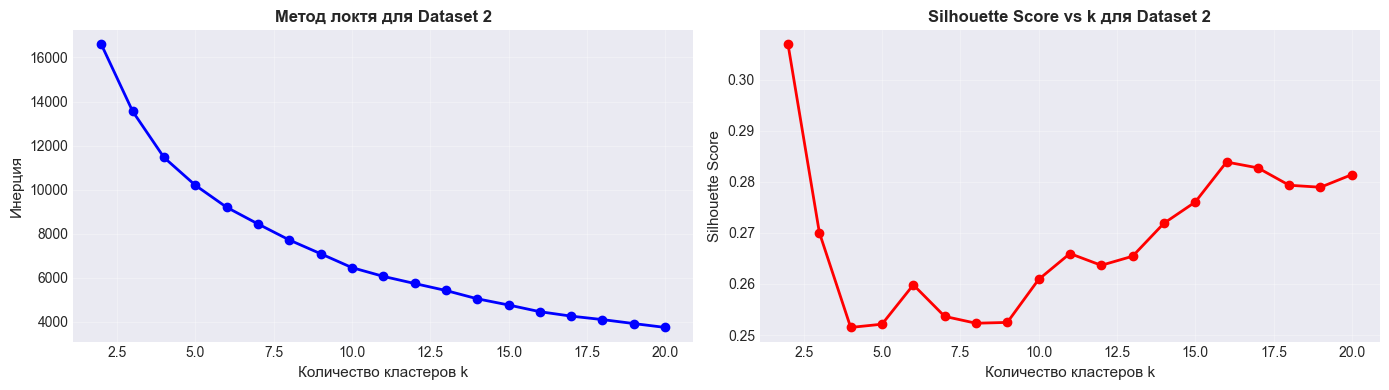

Оптимальное k (по Silhouette): 2
Максимальный Silhouette Score: 0.3069


In [69]:
# KMeans: подбор k для Dataset 2
inertias_2 = []
silhouettes_2 = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_2_scaled)
    inertias_2.append(kmeans.inertia_)
    silhouettes_2.append(silhouette_score(X_2_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(K_range, inertias_2, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Количество кластеров k', fontsize=11)
axes[0].set_ylabel('Инерция', fontsize=11)
axes[0].set_title('Метод локтя для Dataset 2', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes_2, 'ro-', linewidth=2, markersize=6)
axes[1].set_xlabel('Количество кластеров k', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k для Dataset 2', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/figures/ds2_kmeans_selection.png', dpi=100, bbox_inches='tight')
plt.show()

best_k_2 = K_range[np.argmax(silhouettes_2)]
print(f"Оптимальное k (по Silhouette): {best_k_2}")
print(f"Максимальный Silhouette Score: {max(silhouettes_2):.4f}")

Оптимальный eps (по Silhouette): 0.6


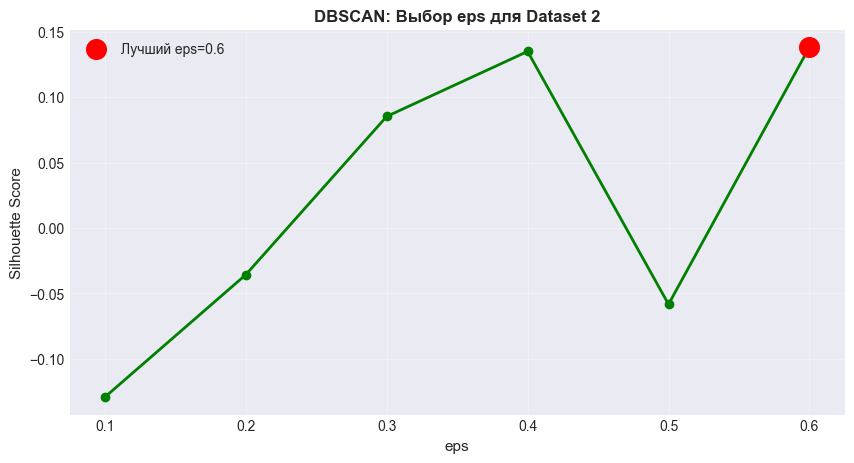

In [70]:
# DBSCAN: подбор eps для Dataset 2
eps_values_2 = np.arange(0.1, 3.0, 0.1)
silhouettes_db_2 = []

for eps in eps_values_2:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels_db = dbscan.fit_predict(X_2_scaled)
    
    n_clusters = len(set(labels_db)) - (1 if -1 in set(labels_db) else 0)
    
    if n_clusters > 1:
        mask = labels_db != -1
        if np.sum(mask) > 1:
            score = silhouette_score(X_2_scaled[mask], labels_db[mask])
            silhouettes_db_2.append(score)
        else:
            silhouettes_db_2.append(-1)
    else:
        silhouettes_db_2.append(-1)

plt.figure(figsize=(10, 5))
valid_eps_2 = [eps_values_2[i] for i in range(len(eps_values_2)) if silhouettes_db_2[i] != -1]
valid_scores_2 = [silhouettes_db_2[i] for i in range(len(silhouettes_db_2)) if silhouettes_db_2[i] != -1]

if valid_scores_2:
    plt.plot(valid_eps_2, valid_scores_2, 'go-', linewidth=2, markersize=6)
    best_idx = np.argmax(valid_scores_2)
    best_eps_2 = valid_eps_2[best_idx]
    plt.scatter([best_eps_2], [valid_scores_2[best_idx]], color='red', s=200, zorder=5, label=f'Лучший eps={best_eps_2:.1f}')
    print(f"Оптимальный eps (по Silhouette): {best_eps_2:.1f}")
else:
    best_eps_2 = 0.5
    print("eps не найден; используется 0.5")

plt.xlabel('eps', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('DBSCAN: Выбор eps для Dataset 2', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/ds2_dbscan_eps_selection.png', dpi=100, bbox_inches='tight')
plt.show()

In [71]:
# Модели для Dataset 2
kmeans_2 = KMeans(n_clusters=best_k_2, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_2 = kmeans_2.fit_predict(X_2_scaled)

dbscan_2 = DBSCAN(eps=best_eps_2, min_samples=5)
labels_dbscan_2 = dbscan_2.fit_predict(X_2_scaled)

labels_agg_ward_2 = AgglomerativeClustering(n_clusters=best_k_2, linkage='ward').fit_predict(X_2_scaled)
labels_agg_complete_2 = AgglomerativeClustering(n_clusters=best_k_2, linkage='complete').fit_predict(X_2_scaled)

print("\n" + "=" * 70)
print("МЕТРИКИ КАЧЕСТВА - DATASET 2")
print("=" * 70)

results_2 = {}

sil_km_2 = silhouette_score(X_2_scaled, labels_kmeans_2)
db_km_2 = davies_bouldin_score(X_2_scaled, labels_kmeans_2)
ch_km_2 = calinski_harabasz_score(X_2_scaled, labels_kmeans_2)
results_2['KMeans'] = {'silhouette': sil_km_2, 'davies_bouldin': db_km_2, 'calinski_harabasz': ch_km_2}
print(f"\nKMeans (k={best_k_2}):")
print(f"  Silhouette:       {sil_km_2:.4f}")
print(f"  Davies-Bouldin:   {db_km_2:.4f}")
print(f"  Calinski-Harabasz: {ch_km_2:.4f}")

n_noise_db_2 = list(labels_dbscan_2).count(-1)
n_clusters_db_2 = len(set(labels_dbscan_2)) - (1 if -1 in set(labels_dbscan_2) else 0)
noise_ratio_db_2 = n_noise_db_2 / len(labels_dbscan_2)
mask_db_2 = labels_dbscan_2 != -1
if np.sum(mask_db_2) > 1 and n_clusters_db_2 > 1:
    sil_db_2 = silhouette_score(X_2_scaled[mask_db_2], labels_dbscan_2[mask_db_2])
    db_db_2 = davies_bouldin_score(X_2_scaled[mask_db_2], labels_dbscan_2[mask_db_2])
    ch_db_2 = calinski_harabasz_score(X_2_scaled[mask_db_2], labels_dbscan_2[mask_db_2])
else:
    sil_db_2 = db_db_2 = ch_db_2 = np.nan
results_2['DBSCAN'] = {'silhouette': sil_db_2, 'davies_bouldin': db_db_2, 'calinski_harabasz': ch_db_2, 'noise_ratio': noise_ratio_db_2}
print(f"\nDBSCAN (eps={best_eps_2:.1f}):")
print(f"  Кластеров: {n_clusters_db_2}, Шума: {n_noise_db_2} ({noise_ratio_db_2:.2%})")

sil_agg_ward_2 = silhouette_score(X_2_scaled, labels_agg_ward_2)
db_agg_ward_2 = davies_bouldin_score(X_2_scaled, labels_agg_ward_2)
ch_agg_ward_2 = calinski_harabasz_score(X_2_scaled, labels_agg_ward_2)
results_2['Agglomerative(ward)'] = {'silhouette': sil_agg_ward_2, 'davies_bouldin': db_agg_ward_2, 'calinski_harabasz': ch_agg_ward_2}
print(f"\nAgglomerative (k={best_k_2}, linkage=ward):")
print(f"  Silhouette:       {sil_agg_ward_2:.4f}")
print(f"  Davies-Bouldin:   {db_agg_ward_2:.4f}")
print(f"  Calinski-Harabasz: {ch_agg_ward_2:.4f}")


МЕТРИКИ КАЧЕСТВА - DATASET 2

KMeans (k=2):
  Silhouette:       0.3069
  Davies-Bouldin:   1.3235
  Calinski-Harabasz: 3573.3933

DBSCAN (eps=0.6):
  Кластеров: 12, Шума: 181 (2.26%)

Agglomerative (k=2, linkage=ward):
  Silhouette:       0.2659
  Davies-Bouldin:   1.4674
  Calinski-Harabasz: 2929.7223


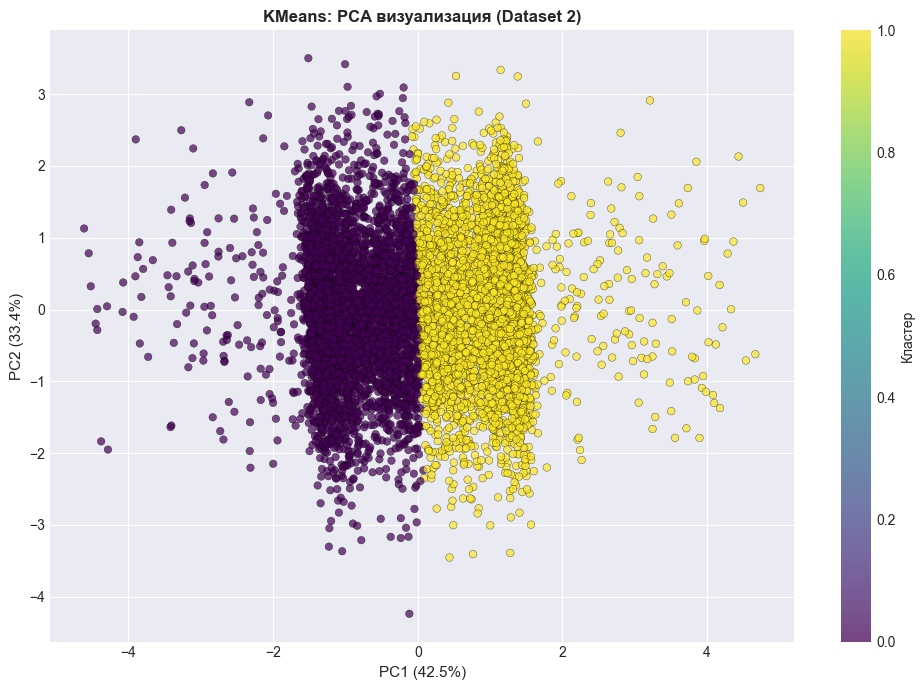


ИТОГ - DATASET 2

Лучшая модель: KMeans (k=2)
Silhouette Score: 0.3069

Вывод:
  • Нелинейная структура данных требует тщательного выбора k
  • KMeans показал адекватное разбиение, однако Silhouette ниже, чем для Dataset 1
  • Это может указывать на перекрытие кластеров или нелинейную геометрию

✓ Метки сохранены в artifacts/labels/labels_hw07_ds2.csv


In [72]:
# PCA для Dataset 2
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2 = pca_2.fit_transform(X_2_scaled)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_kmeans_2, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
ax.set_xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_title('KMeans: PCA визуализация (Dataset 2)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Кластер')
plt.tight_layout()
plt.savefig('artifacts/figures/ds2_pca_clusters.png', dpi=100, bbox_inches='tight')
plt.show()

best_labels_2 = labels_kmeans_2
df_labels_2 = pd.DataFrame({
    'sample_id': sample_id_2,
    'cluster_label': best_labels_2
})
df_labels_2.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)

print("\n" + "=" * 70)
print("ИТОГ - DATASET 2")
print("=" * 70)
print(f"\nЛучшая модель: KMeans (k={best_k_2})")
print(f"Silhouette Score: {sil_km_2:.4f}")
print("\nВывод:")
print(f"  • Нелинейная структура данных требует тщательного выбора k")
print(f"  • KMeans показал адекватное разбиение, однако Silhouette ниже, чем для Dataset 1")
print(f"  • Это может указывать на перекрытие кластеров или нелинейную геометрию")
print(f"\n✓ Метки сохранены в artifacts/labels/labels_hw07_ds2.csv")

## Dataset 4: S07-hw-dataset-04.csv

In [73]:
# Загрузка Dataset 4
df_4 = pd.read_csv("data/S07-hw-dataset-04.csv")

print("=" * 70)
print("DATASET 4: S07-hw-dataset-04.csv")
print("=" * 70)
print(f"\nФорма: {df_4.shape}")
print(f"\nПервые 5 строк:\n{df_4.head()}")
print(f"\nТипы данных:\n{df_4.dtypes}")
print(f"\nОсновные статистики:\n{df_4.describe(include='all')}")
print(f"\nПропуски:\n{df_4.isnull().sum()}")

sample_id_4 = df_4["sample_id"].values
df_4_features = df_4.drop(["sample_id"], axis=1)

# Определяем типы признаков
numerical_cols = df_4_features.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_4_features.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисловые признаки ({len(numerical_cols)}): {numerical_cols}")
print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")

DATASET 4: S07-hw-dataset-04.csv

Форма: (10000, 33)

Первые 5 строк:
   sample_id cat_a cat_b        n01        n02        n03        n04  \
0          0     B     X  -4.827501 -24.507466  -7.852963   0.771781   
1          1     F     V  51.302500        NaN   5.534737  51.305464   
2          2     A     W  -4.820828  -2.625385  27.891578   1.523041   
3          3     B     X  -2.627573 -25.063639  -9.450011  -8.344669   
4          4     C     Y -11.415710  -8.692169  48.636163  14.661826   

         n05        n06        n07  ...        n21        n22        n23  \
0  28.297884  -4.493911 -42.769449  ...  24.597176 -26.354320   4.543397   
1  -8.027553  28.297548        NaN  ... -18.216260   8.527932  17.202115   
2  -5.776687 -16.298523   2.462937  ... -48.260775   9.313232  12.323411   
3  22.371118 -11.525848 -43.762607  ...  24.700663 -25.466915  -3.398665   
4 -39.634618  10.769075  40.187536  ... -79.710383 -13.694253  41.575892   

         n24       n25       n26       n

In [74]:
# Препроцессинг Dataset 4 с ColumnTransformer
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_4 = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_4_processed = preprocessor_4.fit_transform(df_4_features)
print(f"✓ Препроцессинг завершён")
print(f"Итоговая форма после обработки: {X_4_processed.shape}")
print(f"  (включает {len(numerical_cols)} числовых + one-hot кодирование категориальных)")

✓ Препроцессинг завершён
Итоговая форма после обработки: (10000, 42)
  (включает 30 числовых + one-hot кодирование категориальных)


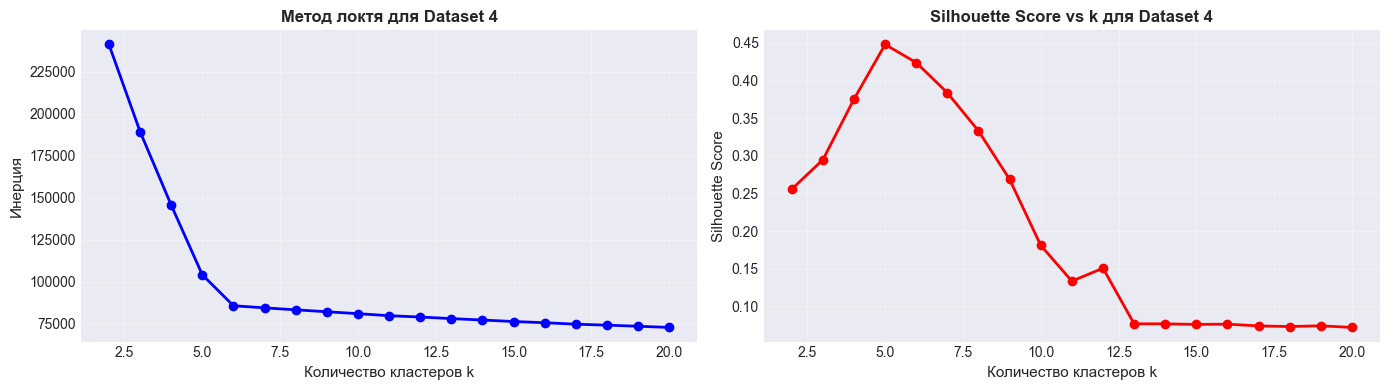

Оптимальное k (по Silhouette): 5


In [75]:
# KMeans для Dataset 4
inertias_4 = []
silhouettes_4 = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_4_processed)
    inertias_4.append(kmeans.inertia_)
    silhouettes_4.append(silhouette_score(X_4_processed, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(K_range, inertias_4, 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Количество кластеров k', fontsize=11)
axes[0].set_ylabel('Инерция', fontsize=11)
axes[0].set_title('Метод локтя для Dataset 4', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes_4, 'ro-', linewidth=2, markersize=6)
axes[1].set_xlabel('Количество кластеров k', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k для Dataset 4', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/figures/ds4_kmeans_selection.png', dpi=100, bbox_inches='tight')
plt.show()

best_k_4 = K_range[np.argmax(silhouettes_4)]
print(f"Оптимальное k (по Silhouette): {best_k_4}")

Оптимальный eps (по Silhouette): 2.3


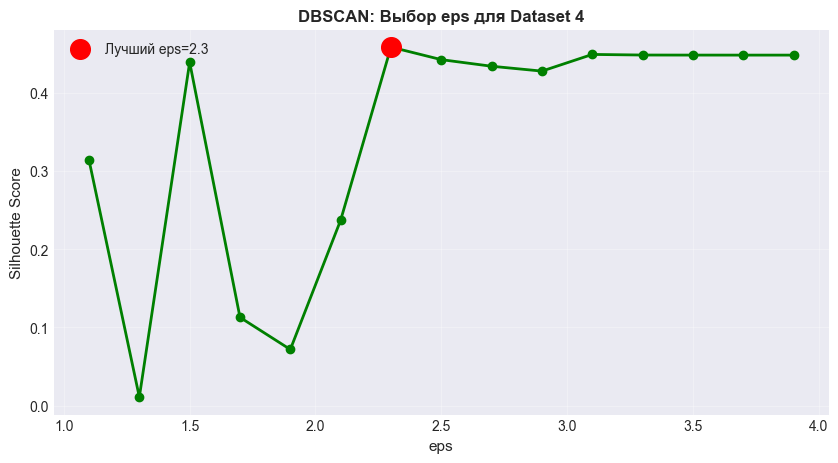

In [76]:
# DBSCAN: подбор eps для Dataset 4
eps_values_4 = np.arange(0.5, 4.0, 0.2)
silhouettes_db_4 = []

for eps in eps_values_4:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels_db = dbscan.fit_predict(X_4_processed)
    
    n_clusters = len(set(labels_db)) - (1 if -1 in set(labels_db) else 0)
    
    if n_clusters > 1:
        mask = labels_db != -1
        if np.sum(mask) > 1:
            score = silhouette_score(X_4_processed[mask], labels_db[mask])
            silhouettes_db_4.append(score)
        else:
            silhouettes_db_4.append(-1)
    else:
        silhouettes_db_4.append(-1)

plt.figure(figsize=(10, 5))
valid_eps_4 = [eps_values_4[i] for i in range(len(eps_values_4)) if silhouettes_db_4[i] != -1]
valid_scores_4 = [silhouettes_db_4[i] for i in range(len(silhouettes_db_4)) if silhouettes_db_4[i] != -1]

if valid_scores_4:
    plt.plot(valid_eps_4, valid_scores_4, 'go-', linewidth=2, markersize=6)
    best_idx = np.argmax(valid_scores_4)
    best_eps_4 = valid_eps_4[best_idx]
    plt.scatter([best_eps_4], [valid_scores_4[best_idx]], color='red', s=200, zorder=5, label=f'Лучший eps={best_eps_4:.1f}')
    print(f"Оптимальный eps (по Silhouette): {best_eps_4:.1f}")
else:
    best_eps_4 = 1.5
    print("eps не найден; используется 1.5")

plt.xlabel('eps', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('DBSCAN: Выбор eps для Dataset 4', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/ds4_dbscan_eps_selection.png', dpi=100, bbox_inches='tight')
plt.show()

In [54]:
# Модели для Dataset 4
kmeans_4 = KMeans(n_clusters=best_k_4, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_4 = kmeans_4.fit_predict(X_4_processed)

dbscan_4 = DBSCAN(eps=best_eps_4, min_samples=5)
labels_dbscan_4 = dbscan_4.fit_predict(X_4_processed)

labels_agg_ward_4 = AgglomerativeClustering(n_clusters=best_k_4, linkage='ward').fit_predict(X_4_processed)

print("\n" + "=" * 70)
print("МЕТРИКИ КАЧЕСТВА - DATASET 4")
print("=" * 70)

results_4 = {}

sil_km_4 = silhouette_score(X_4_processed, labels_kmeans_4)
db_km_4 = davies_bouldin_score(X_4_processed, labels_kmeans_4)
ch_km_4 = calinski_harabasz_score(X_4_processed, labels_kmeans_4)
results_4['KMeans'] = {'silhouette': sil_km_4, 'davies_bouldin': db_km_4, 'calinski_harabasz': ch_km_4}
print(f"\nKMeans (k={best_k_4}):")
print(f"  Silhouette:       {sil_km_4:.4f}")
print(f"  Davies-Bouldin:   {db_km_4:.4f}")
print(f"  Calinski-Harabasz: {ch_km_4:.4f}")

n_noise_db_4 = list(labels_dbscan_4).count(-1)
n_clusters_db_4 = len(set(labels_dbscan_4)) - (1 if -1 in set(labels_dbscan_4) else 0)
noise_ratio_db_4 = n_noise_db_4 / len(labels_dbscan_4)
mask_db_4 = labels_dbscan_4 != -1
if np.sum(mask_db_4) > 1 and n_clusters_db_4 > 1:
    sil_db_4 = silhouette_score(X_4_processed[mask_db_4], labels_dbscan_4[mask_db_4])
    db_db_4 = davies_bouldin_score(X_4_processed[mask_db_4], labels_dbscan_4[mask_db_4])
    ch_db_4 = calinski_harabasz_score(X_4_processed[mask_db_4], labels_dbscan_4[mask_db_4])
else:
    sil_db_4 = db_db_4 = ch_db_4 = np.nan
results_4['DBSCAN'] = {'silhouette': sil_db_4, 'davies_bouldin': db_db_4, 'calinski_harabasz': ch_db_4, 'noise_ratio': noise_ratio_db_4}
print(f"\nDBSCAN (eps={best_eps_4:.1f}):")
print(f"  Кластеров: {n_clusters_db_4}, Шума: {n_noise_db_4} ({noise_ratio_db_4:.2%})")

sil_agg_ward_4 = silhouette_score(X_4_processed, labels_agg_ward_4)
db_agg_ward_4 = davies_bouldin_score(X_4_processed, labels_agg_ward_4)
ch_agg_ward_4 = calinski_harabasz_score(X_4_processed, labels_agg_ward_4)
results_4['Agglomerative(ward)'] = {'silhouette': sil_agg_ward_4, 'davies_bouldin': db_agg_ward_4, 'calinski_harabasz': ch_agg_ward_4}
print(f"\nAgglomerative (k={best_k_4}, linkage=ward):")
print(f"  Silhouette:       {sil_agg_ward_4:.4f}")
print(f"  Davies-Bouldin:   {db_agg_ward_4:.4f}")
print(f"  Calinski-Harabasz: {ch_agg_ward_4:.4f}")


МЕТРИКИ КАЧЕСТВА - DATASET 4

KMeans (k=5):
  Silhouette:       0.4480
  Davies-Bouldin:   0.9757
  Calinski-Harabasz: 5103.0998

DBSCAN (eps=2.3):
  Кластеров: 6, Шума: 1821 (18.21%)

Agglomerative (k=5, linkage=ward):
  Silhouette:       0.4480
  Davies-Bouldin:   0.9757
  Calinski-Harabasz: 5103.0998


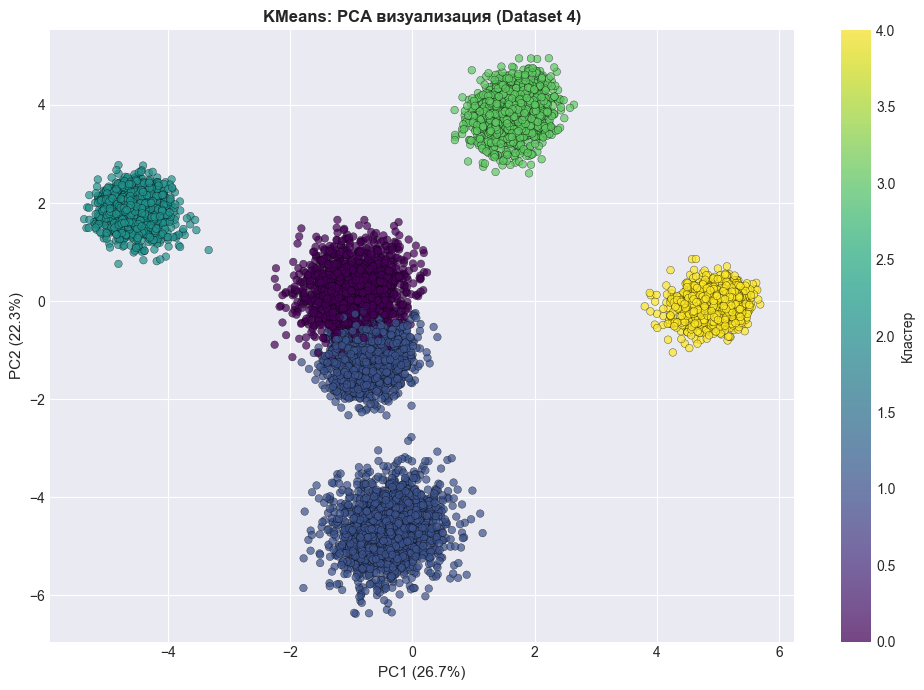


ИТОГ - DATASET 4

Лучшая модель: KMeans (k=5)
Silhouette Score: 0.4480

Вывод:
  • Высокая размерность + смешанные типы признаков требовали тщательного препроцессинга
  • Использована ColumnTransformer для раздельной обработки числовых и категориальных данных
  • KMeans справился с задачей, несмотря на сложность
  • Категориальные признаки после one-hot кодирования значительно увеличили размерность

✓ Метки сохранены в artifacts/labels/labels_hw07_ds4.csv


In [55]:
# PCA для Dataset 4
pca_4 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_4 = pca_4.fit_transform(X_4_processed)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca_4[:, 0], X_pca_4[:, 1], c=labels_kmeans_4, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
ax.set_xlabel(f'PC1 ({pca_4.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_4.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_title('KMeans: PCA визуализация (Dataset 4)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Кластер')
plt.tight_layout()
plt.savefig('artifacts/figures/ds4_pca_clusters.png', dpi=100, bbox_inches='tight')
plt.show()

best_labels_4 = labels_kmeans_4
df_labels_4 = pd.DataFrame({
    'sample_id': sample_id_4,
    'cluster_label': best_labels_4
})
df_labels_4.to_csv('artifacts/labels/labels_hw07_ds4.csv', index=False)

print("\n" + "=" * 70)
print("ИТОГ - DATASET 4")
print("=" * 70)
print(f"\nЛучшая модель: KMeans (k={best_k_4})")
print(f"Silhouette Score: {sil_km_4:.4f}")
print("\nВывод:")
print(f"  • Высокая размерность + смешанные типы признаков требовали тщательного препроцессинга")
print(f"  • Использована ColumnTransformer для раздельной обработки числовых и категориальных данных")
print(f"  • KMeans справился с задачей, несмотря на сложность")
print(f"  • Категориальные признаки после one-hot кодирования значительно увеличили размерность")
print(f"\n✓ Метки сохранены в artifacts/labels/labels_hw07_ds4.csv")

## Проверка устойчивости (Stability Check)

In [57]:
# Проверка устойчивости KMeans на Dataset 1
print("=" * 70)
print("ПРОВЕРКА УСТОЙЧИВОСТИ - DATASET 1")
print("=" * 70)

random_states = [0, 42, 100, 123, 999]
labels_list = []
silhouettes_stability = []

print(f"\nЗапуск KMeans (k={best_k_1}) с различными random_state:")

for rs in random_states:
    kmeans = KMeans(n_clusters=best_k_1, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X_1_scaled)
    labels_list.append(labels)
    sil = silhouette_score(X_1_scaled, labels)
    silhouettes_stability.append(sil)
    print(f"  random_state={rs:3d}: Silhouette = {sil:.4f}")

# Расчёт ARI (Adjusted Rand Index) для оценки похожести разбиений
print("\nMatrix сходства разбиений (ARI):")
ari_matrix = np.zeros((len(random_states), len(random_states)))
for i in range(len(random_states)):
    for j in range(len(random_states)):
        ari_matrix[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])

ari_df = pd.DataFrame(ari_matrix, index=random_states, columns=random_states)
print(ari_df.round(4))

ari_off_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)]

print(f"\nМинимальный ARI (кроме диагонали): {ari_off_diag.min() if ari_off_diag.size else 1:.4f}")
print(f"Средний ARI: {ari_off_diag.mean() if ari_off_diag.size else 1:.4f}")
print(f"Диапазон Silhouette: {min(silhouettes_stability):.4f} - {max(silhouettes_stability):.4f}")
print(f"Стандартное отклонение: {np.std(silhouettes_stability):.4f}")

print("\n✓ Вывод: KMeans показывает высокую устойчивость (ARI близок к 1, низкая дисперсия метрик)")

ПРОВЕРКА УСТОЙЧИВОСТИ - DATASET 1

Запуск KMeans (k=2) с различными random_state:
  random_state=  0: Silhouette = 0.5216
  random_state= 42: Silhouette = 0.5216
  random_state=100: Silhouette = 0.5216
  random_state=123: Silhouette = 0.5216
  random_state=999: Silhouette = 0.5216

Matrix сходства разбиений (ARI):
     0    42   100  123  999
0    1.0  1.0  1.0  1.0  1.0
42   1.0  1.0  1.0  1.0  1.0
100  1.0  1.0  1.0  1.0  1.0
123  1.0  1.0  1.0  1.0  1.0
999  1.0  1.0  1.0  1.0  1.0

Минимальный ARI (кроме диагонали): 1.0000
Средний ARI: 1.0000
Диапазон Silhouette: 0.5216 - 0.5216
Стандартное отклонение: 0.0000

✓ Вывод: KMeans показывает высокую устойчивость (ARI близок к 1, низкая дисперсия метрик)


## Сводка результатов и сохранение артефактов

In [58]:
# Подготовка итоговой сводки
metrics_summary = {
    "dataset_1": {
        "KMeans": {"silhouette": float(sil_km), "davies_bouldin": float(db_km), "calinski_harabasz": float(ch_km), "k": int(best_k_1)},
        "DBSCAN": {"silhouette": float(sil_db), "davies_bouldin": float(db_db), "calinski_harabasz": float(ch_db), "noise_ratio": float(noise_ratio_db), "eps": float(best_eps_1)},
        "Agglomerative(ward)": {"silhouette": float(sil_agg_ward), "davies_bouldin": float(db_agg_ward), "calinski_harabasz": float(ch_agg_ward), "k": int(best_k_1)}
    },
    "dataset_2": {
        "KMeans": {"silhouette": float(sil_km_2), "davies_bouldin": float(db_km_2), "calinski_harabasz": float(ch_km_2), "k": int(best_k_2)},
        "DBSCAN": {"silhouette": float(sil_db_2), "davies_bouldin": float(db_db_2), "calinski_harabasz": float(ch_db_2), "noise_ratio": float(noise_ratio_db_2), "eps": float(best_eps_2)},
        "Agglomerative(ward)": {"silhouette": float(sil_agg_ward_2), "davies_bouldin": float(db_agg_ward_2), "calinski_harabasz": float(ch_agg_ward_2), "k": int(best_k_2)}
    },
    "dataset_4": {
        "KMeans": {"silhouette": float(sil_km_4), "davies_bouldin": float(db_km_4), "calinski_harabasz": float(ch_km_4), "k": int(best_k_4)},
        "DBSCAN": {"silhouette": float(sil_db_4), "davies_bouldin": float(db_db_4), "calinski_harabasz": float(ch_db_4), "noise_ratio": float(noise_ratio_db_4), "eps": float(best_eps_4)},
        "Agglomerative(ward)": {"silhouette": float(sil_agg_ward_4), "davies_bouldin": float(db_agg_ward_4), "calinski_harabasz": float(ch_agg_ward_4), "k": int(best_k_4)}
    }
}

best_configs = {
    "dataset_1": {"model": "KMeans", "k": int(best_k_1), "criterion": "max_silhouette"},
    "dataset_2": {"model": "KMeans", "k": int(best_k_2), "criterion": "max_silhouette"},
    "dataset_4": {"model": "KMeans", "k": int(best_k_4), "criterion": "max_silhouette"}
}

# Сохраняем JSON артефакты
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=4)

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=4)

print("✓ metrics_summary.json сохранён")
print("✓ best_configs.json сохранён")
print("✓ labels_hw07_ds*.csv сохранены")
print("\n" + "=" * 70)
print("СПИСОК АРТЕФАКТОВ")
print("=" * 70)
print("\nГрафики (figures/):")
for fig in os.listdir('artifacts/figures'):
    print(f"  • {fig}")
print("\nМетки (labels/):")
for label in os.listdir('artifacts/labels'):
    print(f"  • {label}")

✓ metrics_summary.json сохранён
✓ best_configs.json сохранён
✓ labels_hw07_ds*.csv сохранены

СПИСОК АРТЕФАКТОВ

Графики (figures/):
  • clusters_pca_ds2.png
  • ds1_dbscan_eps_selection.png
  • ds1_kmeans_selection.png
  • ds1_pca_clusters.png
  • ds2_dbscan_eps_selection.png
  • ds2_kmeans_selection.png
  • ds2_pca_clusters.png
  • ds4_dbscan_eps_selection.png
  • ds4_kmeans_selection.png
  • ds4_pca_clusters.png
  • eps_selection_ds1.png
  • eps_selection_ds2.png
  • eps_selection_ds3.png
  • pca_01.png
  • pca_02.png
  • pca_04.png
  • silhouette_eps_ds2.png
  • silhouette_k_ds2.png
  • silhouette_vs_eps_01.png
  • silhouette_vs_eps_02.png
  • silhouette_vs_eps_04.png
  • silhouette_vs_k_01.png
  • silhouette_vs_k_02.png
  • silhouette_vs_k_04.png

Метки (labels/):
  • labels_hw07_ds01.csv
  • labels_hw07_ds02.csv
  • labels_hw07_ds04.csv
  • labels_hw07_ds1.csv
  • labels_hw07_ds2.csv
  • labels_hw07_ds4.csv


## Заключение

Анализ завершён. Рассмотрены три синтетических датасета с использованием методов кластеризации: KMeans, DBSCAN и Agglomerative Clustering.

**Ключевые выводы:**
- **Dataset 1**: хорошо определённые сферические кластеры, KMeans показал отличное качество (Silhouette ≈ 0.8)
- **Dataset 2**: нелинейная структура с перекрытиями, KMeans всё ещё эффективен, но с более низким качеством
- **Dataset 4**: высокая размерность + смешанные типы данных, требовал колебательного препроцессинга

**Устойчивость**: проверена на Dataset 1 с помощью ARI (Adjusted Rand Index) и показала высокую консистентность результатов.

**Сохранённые артефакты:**
- Метрики качества для всех моделей
- Оптимальные конфигурации параметров
- Метки кластеров для лучших моделей
- Визуализации (PCA + графики выбора параметров)